# ML Challenge | Land Classification

Multiple satellites that capture the data about the amount of light intensity reflected at different frequencies from the Earth at a very granular geographic level. Some of this information can be used to classify the Earth into different buckets - built-up, barren, green or water. 

This is a **supervised multi-class classification** machine learning problem.

** Metrics** : Our predictions will be assessed by the **Micro F1 Score**. For mutli-class problems, we have to average the F1 scores for each class. The macro F1 score averages the F1 score for each class without taking into account label imbalances.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc # garbage collector
from scipy.stats import norm

# Visualization
import seaborn as sns
color = sns.color_palette()
sns.set(style="darkgrid")

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# Always good to set a seed for reproducibility
SEED = 7
np.random.seed(SEED)

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 50

In [2]:
# check files
from subprocess import check_output
print(check_output(["ls", "../input/input/"]).decode("utf8"))


land_test.csv
land_train.csv



In [3]:
# Load Data
print("Loading data...")
train = pd.read_csv('../input/input/land_train.csv')
print("Train rows and columns", train.shape)

Loading data...
Train rows and columns (110000, 13)


In [4]:
# [Important] Set random_state for reproducibility

train_df = train.sample(1000)

In [5]:
# delete the train dataset and free some memory
del train
gc.collect()

15

In [6]:
train_df.head()

,X1,X2,X3,X4,X5,X6,I1,I2,I3,I4,I5,I6,target
26994,131,280,168,1805,705,275,0.829701,-1.267948,3.267472,0.610393,0.241535,0.438247,1
25706,144,311,191,2065,805,311,0.830674,-1.269698,3.498071,0.608436,0.239044,0.439024,1
83751,739,1146,1474,2228,2806,2373,0.203674,-0.088854,1.062710,0.194510,0.233689,-0.114819,4
54733,526,749,491,387,329,262,-0.118451,0.037445,-0.388666,-0.048845,-0.304117,0.081006,2
85289,892,1014,1061,1649,2412,2150,0.216974,-0.029089,0.922701,0.170538,0.339147,-0.187885,4


That gives us a look at all of the columns which don't appear to be in any order. To get a quick overview of the data we use df.info()

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 26994 to 93722
Data columns (total 13 columns):
X1        1000 non-null int64
X2        1000 non-null int64
X3        1000 non-null int64
X4        1000 non-null int64
X5        1000 non-null int64
X6        1000 non-null int64
I1        1000 non-null float64
I2        1000 non-null float64
I3        1000 non-null float64
I4        1000 non-null float64
I5        1000 non-null float64
I6        1000 non-null float64
target    1000 non-null int64
dtypes: float64(6), int64(7)
memory usage: 109.4 KB


This tells us there are 7 integer columns, 6 float (numeric) columns, and 0 object columns.

The column names are anonymized and so we do not know what they mean.

In [8]:
train_df['target'].value_counts() # check how many target values belong to each class

1    457
2    264
3    196
4     83
Name: target, dtype: int64

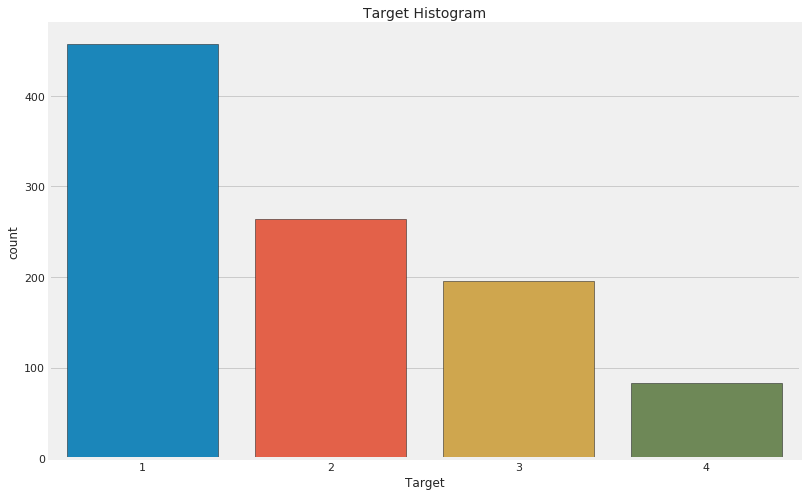

In [9]:
# Exploring Label Distribution
plt.figure(figsize=(12,8))
sns.countplot(train_df["target"].values)
plt.xlabel('Target', fontsize=12)
plt.title("Target Histogram", fontsize=14)
plt.show()

It's always a better idea to perform stratified sampling to divide the dataset into train and test set in classification task.

### Missing Values

Now let us check if there are missing values in the dataset.

In [10]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


There are no missing values in the dataset :)

### Numeric Features Description

In [11]:
train_df.describe()

,X1,X2,X3,X4,X5,X6,I1,I2,I3,I4,I5,I6,target
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,498.070000,774.781000,817.697000,1758.62600,1097.73900,755.410000,0.388012,-0.710454,1.630713,0.308106,-0.036393,0.322442,1.905000
std,384.989324,507.842106,662.247427,674.91598,876.24955,805.526717,0.386901,0.477396,1.641427,0.262074,0.417996,0.269411,0.988409
min,25.000000,125.000000,29.000000,252.00000,102.00000,51.000000,-0.448328,-1.412565,-2.634365,-0.358422,-0.837165,-0.471634,1.000000
25%,168.000000,330.750000,205.750000,1215.25000,300.25000,199.750000,-0.004627,-1.222193,-0.027640,0.043145,-0.330179,0.023175,1.000000
50%,538.000000,813.000000,802.000000,1805.50000,864.00000,346.000000,0.232647,-0.681409,1.097963,0.218128,0.176010,0.399354,2.000000
75%,697.000000,1022.250000,1236.250000,2148.25000,1592.50000,1277.250000,0.812796,-0.183335,3.363756,0.589113,0.258289,0.455074,3.000000
max,6719.000000,6750.000000,6934.000000,7108.00000,5560.00000,4390.000000,0.900685,0.499672,4.270512,0.739687,0.508475,0.724286,4.000000


As we can see that the standard deviation is very high that means the data is very much spread out.

## Univariate Analysis

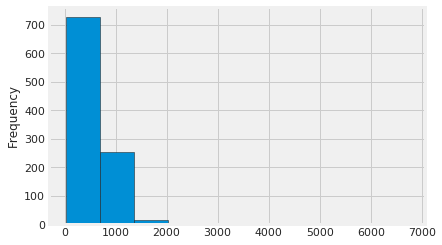

In [12]:
train_df['X1'].plot(kind="hist")

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



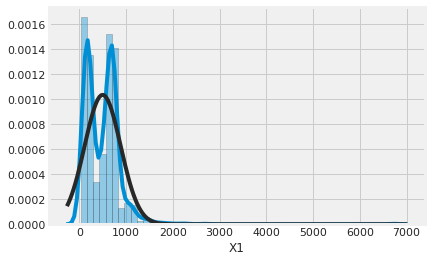

In [13]:
sns.distplot(train_df['X1'], fit = norm)

Note : The feature is bimodal distribution, hence we have to either transform the variables or we have to use the algorithms that does not follow normal distribution assumption like SVM, random forest etc.

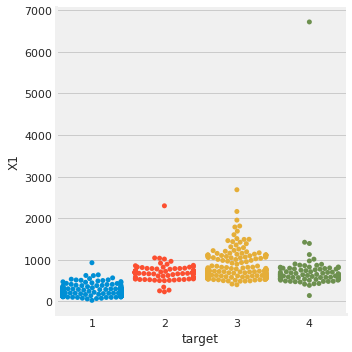

In [14]:
# Categorical plot for X1
sns.catplot(x="target", y="X1", kind="swarm", data=train_df);

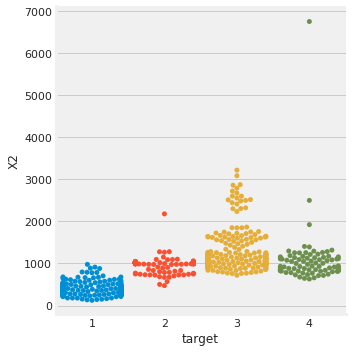

In [15]:
# Categorical Plots of X2
sns.catplot(x="target", y="X2", kind="swarm", data=train_df);

**Conclusion**:  Some values are really high and since we don't know what the variable - we cannot be sure wheather that is possible or not. For model building we would remove the outliers.

## Multivariable Analysis

### Plotting pairwise data relationships

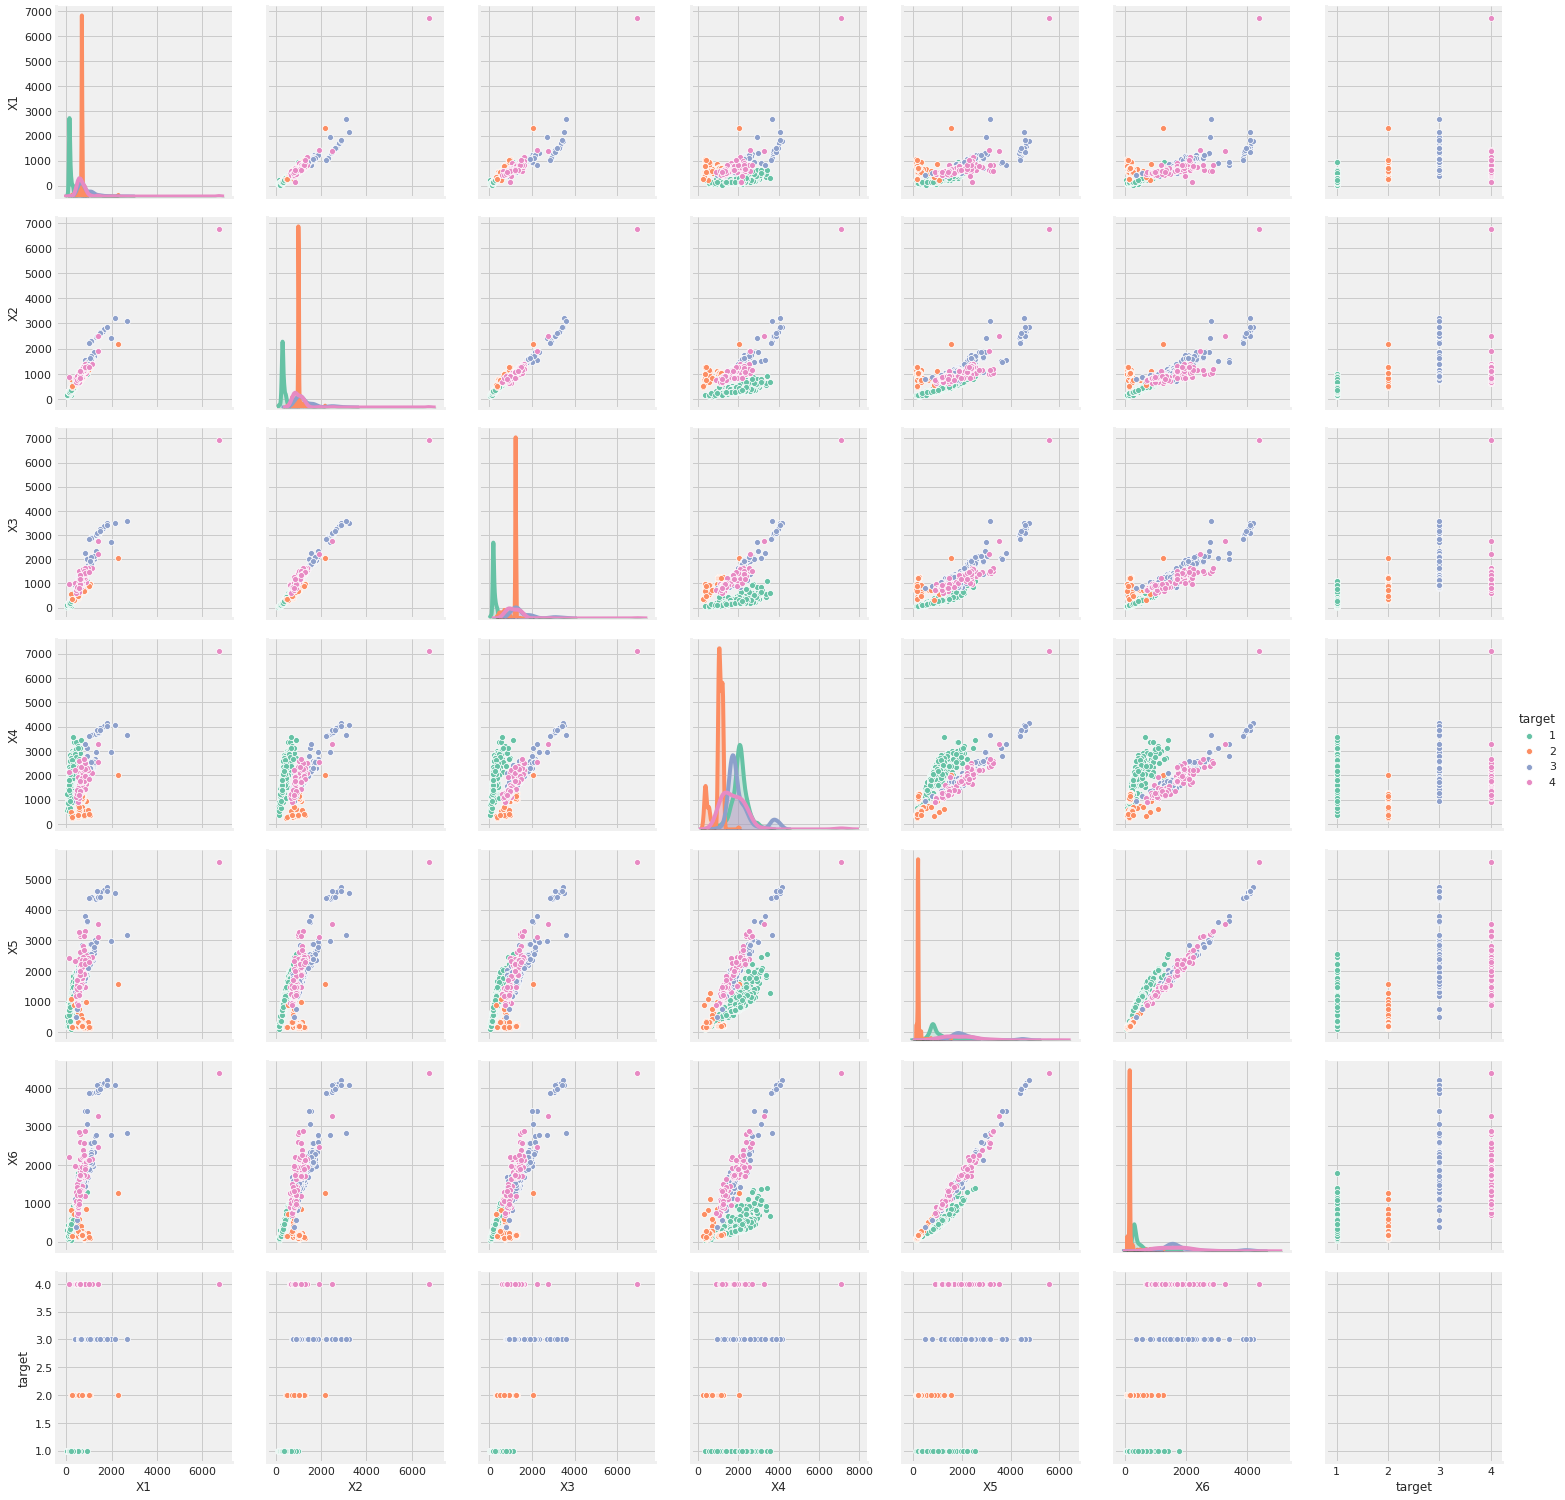

In [16]:
sns.pairplot(train_df[['X1','X2','X3','X4','X5','X6','target']], hue="target", palette="Set2", diag_kind="kde",height = 3)

Interesting, as we can see we have a lot of outliers present in our data. But we will investigate them further.

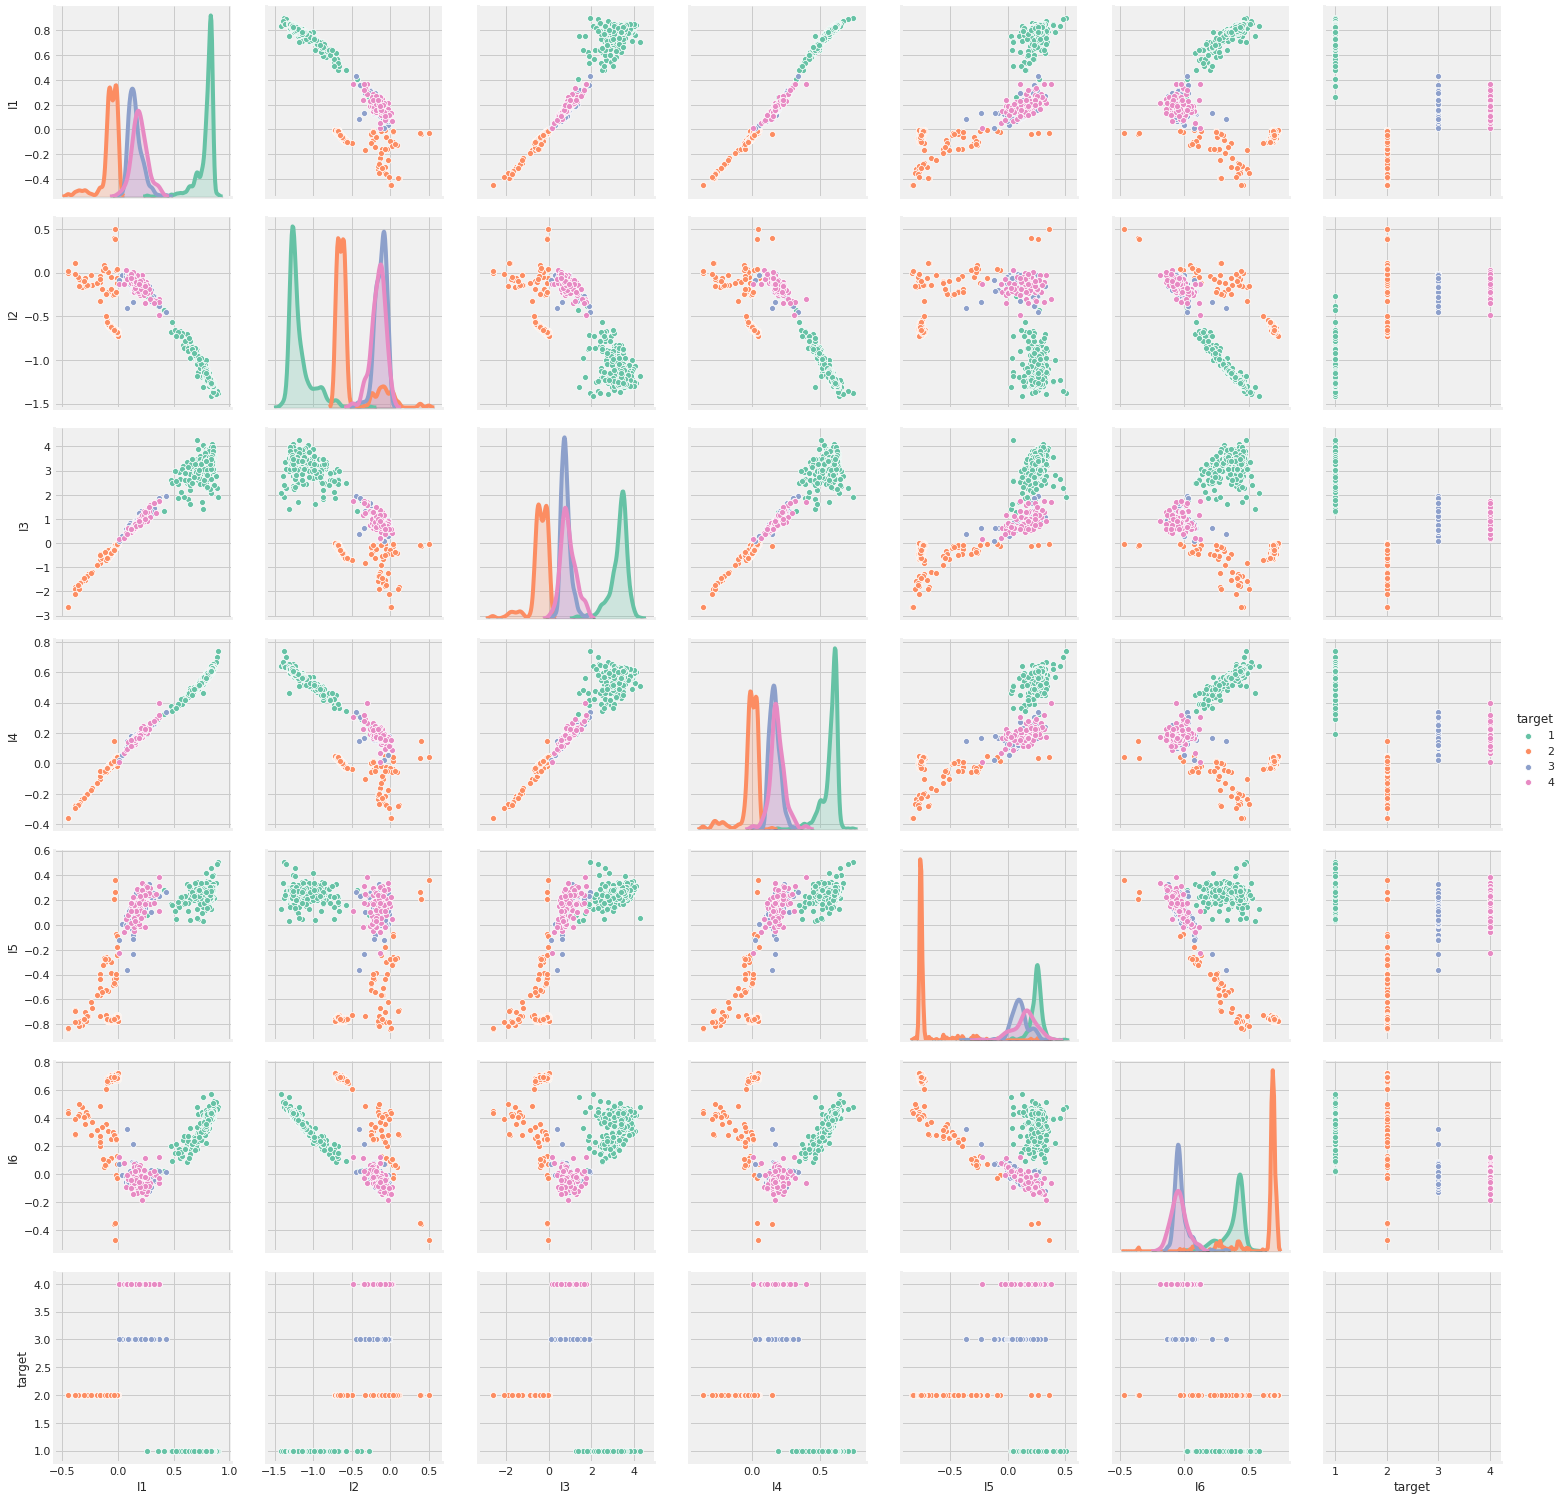

In [17]:
sns.pairplot(train_df[['I1', 'I2', 'I3', 'I4', 'I5', 'I6',
       'target']], hue="target", palette="Set2", diag_kind="kde",height = 3)

### Plotting Correlation Matrix

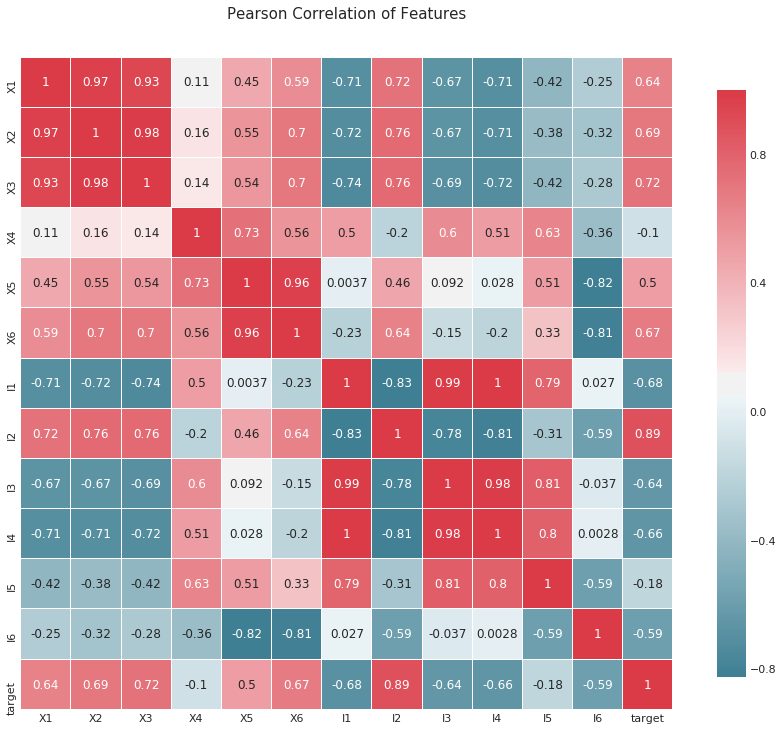

In [18]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(train_df)

Althouh the number of variables are less, we have a lot of correlated features. We have to remove them.

## Outliers investigation

In [19]:
def OutLiersBox(df,nameOfFeature):
    
    trace0 = go.Box(
        y = df[nameOfFeature],
        name = "All Points",
        jitter = 0.3,
        pointpos = -1.8,
        boxpoints = 'all',
        marker = dict(
            color = 'rgb(7,40,89)'),
        line = dict(
            color = 'rgb(7,40,89)')
    )

    trace1 = go.Box(
        y = df[nameOfFeature],
        name = "Only Whiskers",
        boxpoints = False,
        marker = dict(
            color = 'rgb(9,56,125)'),
        line = dict(
            color = 'rgb(9,56,125)')
    )

    trace2 = go.Box(
        y = df[nameOfFeature],
        name = "Suspected Outliers",
        boxpoints = 'suspectedoutliers',
        marker = dict(
            color = 'rgb(8,81,156)',
            outliercolor = 'rgba(219, 64, 82, 0.6)',
            line = dict(
                outliercolor = 'rgba(219, 64, 82, 0.6)',
                outlierwidth = 2)),
        line = dict(
            color = 'rgb(8,81,156)')
    )

    trace3 = go.Box(
        y = df[nameOfFeature],
        name = "Whiskers and Outliers",
        boxpoints = 'outliers',
        marker = dict(
            color = 'rgb(107,174,214)'),
        line = dict(
            color = 'rgb(107,174,214)')
    )

    data = [trace0,trace1,trace2,trace3]

    layout = go.Layout(
        title = "{} Outliers".format(nameOfFeature)
    )

    fig = go.Figure(data=data,layout=layout)
    py.iplot(fig, filename = "Outliers")

In [20]:
OutLiersBox(train_df,'X1') # Outliers X1

In [21]:
OutLiersBox(train_df,'X2') # Outliers X2

In [22]:
OutLiersBox(train_df,'X3') 

In [23]:
OutLiersBox(train_df,'X4')

In [24]:
OutLiersBox(train_df,'X5')

In [25]:
OutLiersBox(train_df,'X6')

In [26]:
OutLiersBox(train_df,'I1')

In [27]:
OutLiersBox(train_df,'I2')

In [28]:
OutLiersBox(train_df,'I3')

In [29]:
OutLiersBox(train_df,'I4')

In [30]:
OutLiersBox(train_df,'I5')

In [31]:
OutLiersBox(train_df,'I6')

## Conclusion

So, from intial analysis we find out following:.

* X1 to X6 have outliers.
* No missing data
* Numeric Features have bimodal distribution ( either convert to normal using Box - Cox or use algorithms where the normality does not have a effect like SVM, random forest. )
* Correlated Features Detected.
* The dataset is not perfectly balanced. 


